# Store Sales - Time Series Forecasting
---

Using machine learning to predict grocery sales

In this notebook we will be solving the problem from the competiton: [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting) from [Kaggle](https://www.kaggle.com/)

### Summary:
*   In this competition, you’ll use time-series forecasting to forecast store sales on data from **Corporación Favorita**, a large Ecuadorian-based grocery retailer.
    *   Specifically, you'll build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores.  
    You'll practice your machine learning skills with an approachable training dataset of dates, store, and item information, promotions, and unit sales.

* The evaluation metric for this competition is Root Mean Squared Logarithmic Error - RMSLE.

### File Descriptions and Data Field Information

#### `train.csv`
The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

*   **store_nbr** identifies the store at which the products are sold.
*   **family** identifies the type of product sold.
*   **sales** gives the total sales for a product family at a particular store at a given date.  
    Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
*   **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

#### `test.csv`
The test data, having the same features as the training data.  
You will predict the target sales for the dates in this file.  
*   The dates in the test data are for the 15 days after the last date in the training data.

#### `sample_submission.csv`
*   A sample submission file in the correct format.

#### `stores.csv`
Store metadata, including city, state, type, and cluster.
*   **cluster** is a grouping of similar stores.

#### `oil.csv`
Daily oil price.  
Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

#### `holidays_events.csv`
Holidays and Events, with metadata  


### NOTES:
Pay special attention to the transferred column.  
*   A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government.

*   A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is **Transfer**.  
    *   For example, the holiday ***Independencia de Guayaquil*** was transferred from **2012-10-09** to **2012-10-12**, which means it was celebrated on **2012-10-12**.  

*   Days that are type **Bridge** are extra days that are added to a holiday (e.g., to extend the break across a long weekend).  

*   These are frequently made up by the type **Work Day** which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the **Bridge**.

*   Additional holidays are days added a regular calendar holiday, for example, as typically happens around **Christmas** (making Christmas Eve a holiday).

*   Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. **Supermarket sales could be affected by this.**

*   A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

Extracting file from the `.zip`

In [1]:
import zipfile
from pathlib import Path
import utils

Path("data").mkdir(parents=True, exist_ok=True)

file_path = Path("data/train.csv")
if not file_path.is_file():
    with zipfile.ZipFile("./store-sales-time-series-forecasting.zip", 'r') as zf:
        zf.extractall("./data/")

Reading the `train.csv` file:

In [2]:
import pandas as pd
import numpy as np
train_path = "./data/train.csv"

sales = pd.read_csv(
    train_path,
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date']
    )

sales = sales.set_index('date').to_period('D')
sales = sales.set_index(['store_nbr', 'family'], append=True)
average_sales = sales.groupby('date').mean()['sales']

Let's check how the dataset is composed:

In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3000888 entries, (Period('2013-01-01', 'D'), '1', 'AUTOMOTIVE') to (Period('2017-08-15', 'D'), '9', 'SEAFOOD')
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   sales   float64
dtypes: float64(1)
memory usage: 34.4 MB


In [4]:
sales.describe()

,sales
count,3.000888e+06
mean,3.577757e+02
std,1.101998e+03
min,0.000000e+00
25%,0.000000e+00
50%,1.100000e+01
75%,1.958473e+02
max,1.247170e+05


In [5]:
stores = pd.read_csv("./data/stores.csv")

stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Defining some parameters for the plots:

In [6]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

Plotting a graph for the average sales:

In [7]:
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
Freq: D, Name: sales, dtype: float64

Text(0.5, 1.0, 'Average Sales (2013 - 2017)')

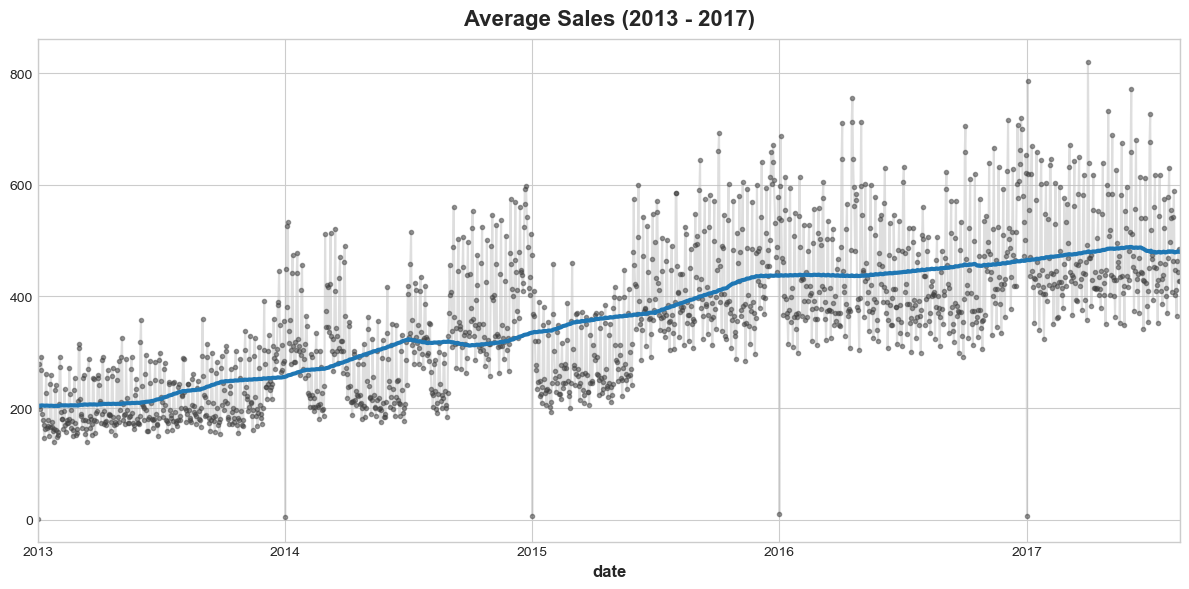

In [8]:
import matplotlib.pyplot as plt

trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

plt.figure(figsize=(12, 6))
ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)
ax.set_title("Average Sales (2013 - 2017)")

## Training our first model for TimeSeries
---

For training the model:
*   First let's unstack our index, making every index from the MultiIndex became a feature;
*   For this model we will use DeterministicProcess from statsmodels
*   We will be also using CalendarFourier from statsmodels tsa (Time Series Analysis) module.

In [9]:
y_targets = sales.unstack(['store_nbr', 'family'])

For the first model, let's start using only 1 year -> **2017**

In [10]:
y_targets = y_targets.loc['2017']

Now let's create our training data:

In [11]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(
    freq='M',
    order=4
)

dp = DeterministicProcess(
    index=y_targets.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)

X = dp.in_sample()

In [12]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869


In [13]:
X['NewYear'] = (X.index.dayofyear == 1)

X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYear
date,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,True
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,False
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,False
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,False
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,False


Let's train the model:

In [14]:
from sklearn.linear_model import LinearRegression


model = LinearRegression(fit_intercept=False)
model.fit(X, y_targets)

y_predicted = pd.DataFrame(
    data=model.predict(X),
    index=X.index,
    columns=y_targets.columns
)

y_predicted.head()

sales                                                      \
store_nbr              1                                                       
family        AUTOMOTIVE BABY CARE        BEAUTY     BEVERAGES         BOOKS   
date                                                                           
2017-01-01 -5.218048e-14       0.0 -2.753353e-14  2.728484e-12  3.108624e-15   
2017-01-02  4.158065e+00       0.0  3.693728e+00  2.438526e+03  6.524888e-01   
2017-01-03  4.019103e+00       0.0  3.790063e+00  2.556636e+03  9.822520e-01   
2017-01-04  4.086815e+00       0.0  3.626226e+00  2.722500e+03  1.070364e+00   
2017-01-05  3.927327e+00       0.0  3.109574e+00  2.342817e+03  7.886527e-01   

                                                                    \
store_nbr                                                            
family      BREAD/BAKERY   CELEBRATION      CLEANING         DAIRY   
date                                                                 
2017-01-01  1.335820e-12 -1.305622e-13 -6.139089e-12 -4.547474e-13   
2017-01-02  4.339072e+02  1.278250e+01  7.314578e+02  8.363691e+02   
2017-01-03  4.272647e+02  1.496032e+01  8.624653e+02  8.416939e+02   
2017-01-04  5.002280e+02  1.550328e+01  9.660105e+02  9.806785e+02   
2017-01-05  4.429722e+02  1.901495e+01  7.928288e+02  8.212025e+02   

                          ...                                            \
store_nbr                 ...             9                               
family              DELI  ...     MAGAZINES         MEATS PERSONAL CARE   
date                      ...                                             
2017-01-01  6.394885e-13  ... -2.131628e-14  1.364242e-12  2.614797e-12   
2017-01-02  1.590167e+02  ...  3.372874e+00  5.205468e+02  8.060135e+02   
2017-01-03  1.538898e+02  ...  2.618076e+00  4.814580e+02  7.538661e+02   
2017-01-04  1.578011e+02  ...  2.058240e+00  4.258345e+02  6.297048e+02   
2017-01-05  1.313682e+02  ...  1.693960e+00  5.888703e+02  5.486101e+02   

                                                                               \
store_nbr                                                                       
family      PET SUPPLIES PLAYERS AND ELECTRONICS       POULTRY PREPARED FOODS   
date                                                                            
2017-01-01 -1.953993e-14           -7.815970e-14  2.273737e-13   3.126388e-13   
2017-01-02  9.774855e+00            1.951512e+01  5.960566e+02   1.351610e+02   
2017-01-03  8.359401e+00            1.800615e+01  5.495394e+02   1.304207e+02   
2017-01-04  8.577979e+00            1.546256e+01  4.735746e+02   1.162081e+02   
2017-01-05  5.928875e+00            1.401548e+01  4.097657e+02   1.107939e+02   

                                                                   
store_nbr                                                          
family           PRODUCE SCHOOL AND OFFICE SUPPLIES       SEAFOOD  
date                                                               
2017-01-01 -2.728484e-12               1.163514e-13  1.563194e-13  
2017-01-02  2.030560e+03              -6.284309e+00  1.908638e+01  
2017-01-03  2.799504e+03               1.054938e+00  1.826387e+01  
2017-01-04  1.612567e+03              -4.966515e+00  1.547805e+01  
2017-01-05  1.496643e+03              -4.043700e+00  1.342527e+01  

[5 rows x 1782 columns]

Now let's see how or models work for a specified family:
*   In this case we will use `family = 'AUTOMOTIVE'`

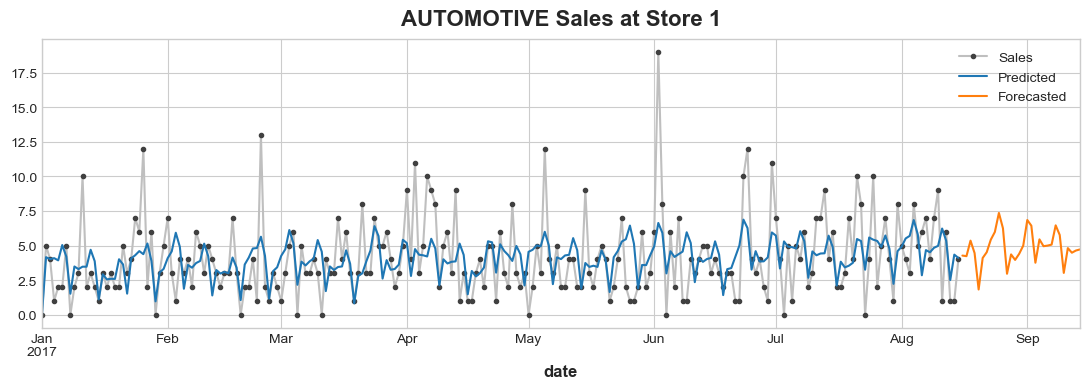

In [15]:
FAMILY = 'AUTOMOTIVE'
STORE = '1'

X_forecasted = dp.out_of_sample(30)
X_forecasted["NewYear"] = (X_forecasted.index.dayofyear == 1)

y_forecasted = pd.DataFrame(
    data=model.predict(X_forecasted),
    index=X_forecasted.index,
    columns=y_targets.columns
)

ax = y_targets.loc(axis=1)['sales', STORE, FAMILY].plot(**plot_params, label='Sales')
ax = y_predicted.loc(axis=1)['sales', STORE, FAMILY].plot(ax=ax, label='Predicted')
ax = y_forecasted.loc(axis=1)['sales', STORE, FAMILY].plot(ax=ax, label='Forecasted')
ax.set_title(f'{FAMILY} Sales at Store {STORE}')
ax.legend()

plt.show()

Creating the first submission to Kaggle:

In [16]:
df_test = pd.read_csv(
    './data/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['date', 'store_nbr', 'family',]).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=df_test.index.get_level_values('date').unique().shape[0])
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y_targets.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test['id']).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

## Using time series as features
---
Some time series properties can only be modeled as serially dependent properties, that is, using as features past values of the target series.

### Lagged Series and Lag Plots
To investigate possible serial dependence (like cycles) in a time series, we need to create "lagged" copies of the series. Lagging a time series means to shift its values forward one or more time steps, or equivalently, to shift the times in its index backward one or more steps. In either case, the effect is that the observations in the lagged series will appear to have happened later in time.

This shows the monthly unemployment rate in the US (`y`) together with its first and second lagged series (`y_lag_1` and `y_lag_2`, respectively). Notice how the values of the lagged series are shifted forward in time.

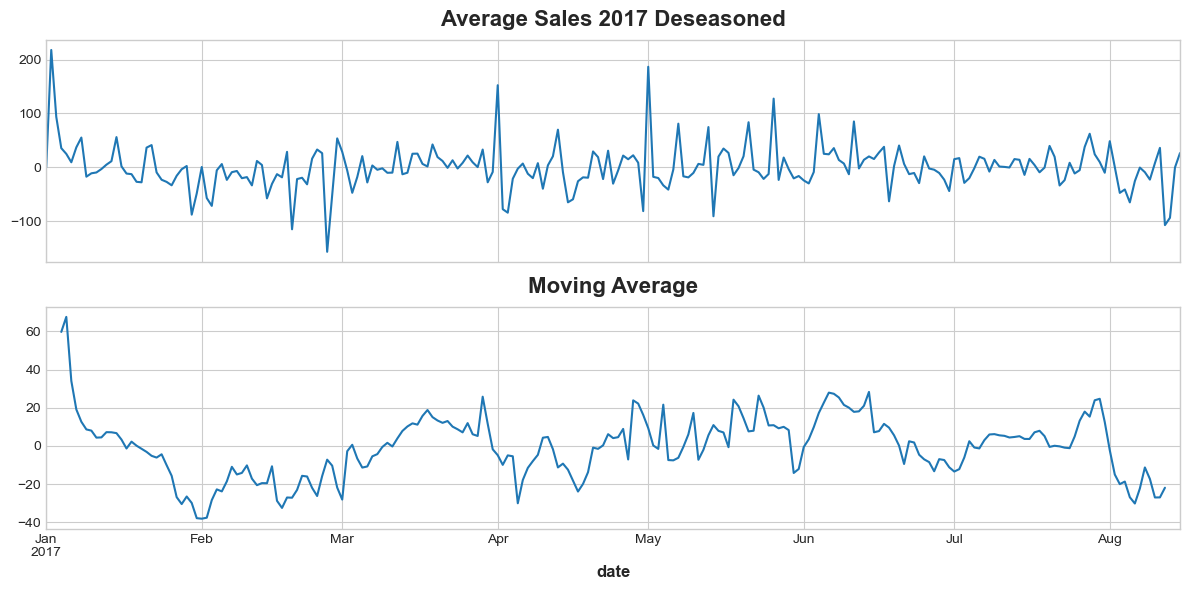

In [17]:
# First, let's check if `average sales` has cyclic behavior:

average_sales_2017 = average_sales.loc['2017']

fourier = CalendarFourier(
    freq='M',
    order=4
)
dp = DeterministicProcess(
    index=average_sales_2017.index,
    constant=True,
    order=1,
    seasonal=True,
    drop=False,
    additional_terms=[fourier]
)

X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, average_sales_2017)

average_deseason = average_sales_2017 - model.predict(X)
average_deseason.name = 'average_sales_deseasoned'

# Moving average
moving_avg = average_deseason.rolling(
    window=7,
    center=True
).mean()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

fig.set_size_inches(12, 6)

average_deseason.plot(ax=ax1, title='Average Sales 2017 Deseasoned')
moving_avg.plot(ax=ax2, title='Moving Average')

plt.show()

Looking at the average sales deseasoned and her moving average, we can't see clearly a cyclic behavior.

Let's check for a specific Product Family: **SCHOOL AND OFFICE SUPPLIES** and see how it goes

In [18]:
sales = pd.read_csv(
    train_path,
    usecols=['family', 'date', 'sales', 'onpromotion'],
    dtype={
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date']
    )

family_sales = (
    sales
    .groupby(['family', 'date'], observed=True)
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

Text(0.5, 1.0, 'Seven-Day Moving Average')

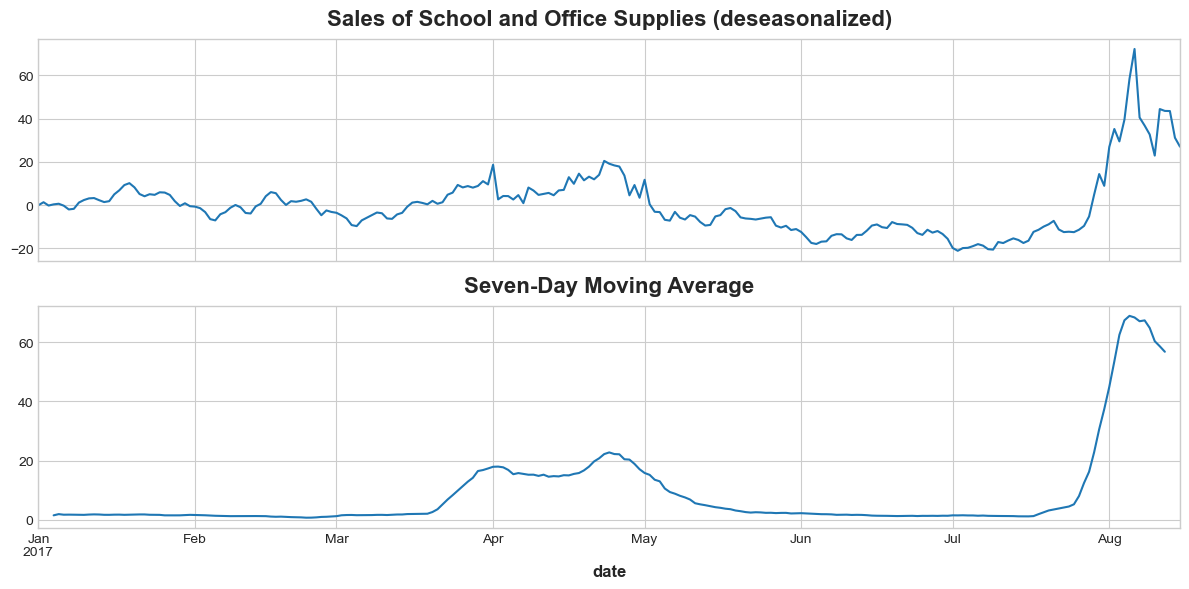

In [19]:

ofc_sup_sales_2017 = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']

y = ofc_sup_sales_2017.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(
    freq='M',
    order=4
)
dp = DeterministicProcess(
    index=average_sales_2017.index,
    constant=True,
    order=1,
    seasonal=True,
    drop=False,
    additional_terms=[fourier]
)

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.set_size_inches(12, 6)

y_deseason.plot(ax=ax1)
ax1.set_title("Sales of School and Office Supplies (deseasonalized)")

y_ma = y.rolling(
    window=7,
    center=True
).mean()

y_ma.plot(ax=ax2)
ax2.set_title("Seven-Day Moving Average")

Training RMSLE: 0.83205
Validation RMSLE: 1.17316


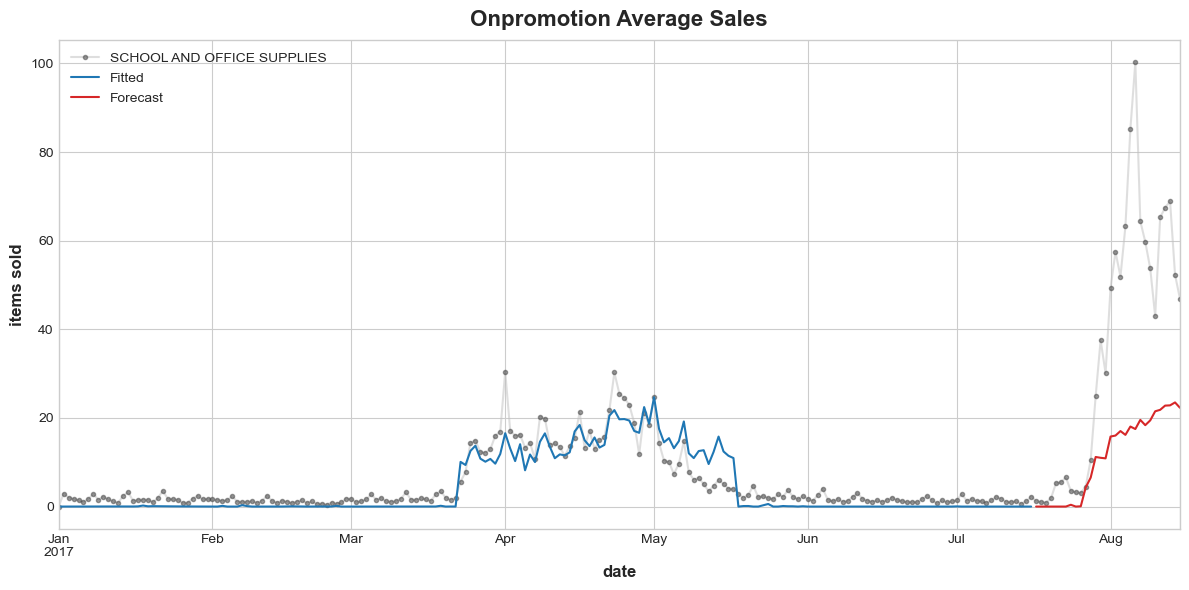

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from utils import make_lags, make_leads

onpromotion = ofc_sup_sales_2017.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

X_lags = make_lags(y_deseason, lags=1)

X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1)
], axis=1)

X = pd.concat([X_lags, X_promo], axis=1)
y, X = y.align(X, join='inner')

X = X.fillna(0.0)


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit)**0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred)**0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

plt.figure(figsize=(12, 6))
ax = y.plot(**plot_params, alpha=0.5, title="Onpromotion Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend()

plt.show()

## Second approach: Using all data to build a hybrid model
---
In this second attempt to decrease RMSLE, we will be using all of the Data that were provided for the competition:
*   `train.csv`
*   `stores.csv`
*   `oil.csv`
*   `holidays_events.csv`

In [21]:
# Importing all libraries we are going to use:
import pandas as pd
import numpy as np
from utils import *
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [22]:
# Assign all files to a variable:
sales = pd.read_csv('./data/train.csv', dtype={'date':'str'}, parse_dates=['date'])
stores = pd.read_csv('./data/stores.csv')
oil = pd.read_csv('./data/oil.csv', dtype={'date':'str'}, parse_dates=['date'])
holidays = pd.read_csv('./data/holidays_events.csv', dtype={'date':'str'}, parse_dates=['date'])

Merging the datasets:

In [23]:
sales = pd.merge(sales, oil, on='date', how='left')

In [29]:
sales = pd.merge(sales, holidays, on='date', how='left')

In [30]:
sales

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
